In [1]:
import  requests
from bs4 import BeautifulSoup
import pandas as pd


# MTA Turnstile Data Analysis

### 1. Define the route and location of the data

In [2]:
#Location of the data
url = 'http://web.mta.info/developers/turnstile.html'
#relative path of the data
#will be formated as http://web.mta.info/developers/data/nyct/turnstile/[file name].txt
route = 'data/nyct/turnstile/'

## 2. Access location, get and parse html content 

In [3]:
#perform a get request on the url
page = requests.get(url)
#parse its html to query and access the page elements
content = BeautifulSoup(page.content, "html.parser")

#query all 'a' element 
links = content.find_all('a')

## 3. Extrct relevant links

In [4]:
data_links = []
for link in links:
    #try accessing the href attribute of the tag, otherwise continue since it doesn't have one
    try:
        #if file is stored in the rout 'data/nyct/turnstile/' then we will save it, else continue
        if route in link['href']:
            data_links.append("http://web.mta.info/developers/" + link["href"])
        else:
            continue
    except KeyError:
        continue
print(len(data_links))#->591

592


## 4. Load data, create dataframe

In [5]:
#load and read data 
#combine all data into a single dataframe
df = pd.concat([pd.read_csv(link,parse_dates=[['DATE','TIME']], keep_date_col=True) for link in data_links[0:12]])

In [6]:
del BeautifulSoup, content, data_links, link, links, page, requests,route, url

In [7]:

%whos

Variable   Type         Data/Info
---------------------------------
df         DataFrame                     DATE_TIM<...>513308 rows x 12 columns]
pd         module       <module 'pandas' from '/u<...>ages/pandas/__init__.py'>


## 5. Preview data

In [8]:
print(df.columns)

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')


In [9]:
#remove white space in last column 
df.rename(columns = {df.columns[-1]:df.columns[-1].strip()},inplace = True)
print(df.columns)

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')


In [10]:
df

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2021-08-28 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,00:00:00,REGULAR,7625998,2609113
1,2021-08-28 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,04:00:00,REGULAR,7626014,2609117
2,2021-08-28 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,08:00:00,REGULAR,7626024,2609135
3,2021-08-28 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,12:00:00,REGULAR,7626086,2609191
4,2021-08-28 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/28/2021,16:00:00,REGULAR,7626206,2609221
...,...,...,...,...,...,...,...,...,...,...,...,...
209255,2021-06-18 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,05:00:00,REGULAR,5554,584
209256,2021-06-18 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,09:00:00,REGULAR,5554,584
209257,2021-06-18 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,13:00:00,REGULAR,5554,584
209258,2021-06-18 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/18/2021,17:00:00,REGULAR,5554,584


In [15]:
df.duplicated().value_counts()

False    2513308
dtype: int64

## 6. Data cleaning and preperation

In [259]:
roos = df[df.STATION == 'RIT-ROOSEVELT'].sort_values("ENTRIES", ascending=False).copy(deep = True)

roos.drop(roos[roos.ENTRIES<0].index, inplace = True)
diff = []
for i in range(0,len(roos.ENTRIES)):
  try:
    diff.append(roos.ENTRIES.iloc[i]-roos.ENTRIES.iloc[i+1])
  except IndexError:
    break
roos.index = range(len(roos.index))
#
roos.drop(roos.index[0], inplace = True)
roos.ENTRIES = diff
roos = roos.groupby(['TIME','DATE'], dropna=True).ENTRIES.sum().reset_index()
roos.sort_values(by='ENTRIES', ascending = False).head(10)
roos.drop([roos.index[510],roos.index[172]], inplace = True)

[Text(0, 0, '01:00:00'),
 Text(0, 0, '05:00:00'),
 Text(0, 0, '07:31:50'),
 Text(0, 0, '08:52:59'),
 Text(0, 0, '09:00:00'),
 Text(0, 0, '09:12:54'),
 Text(0, 0, '09:37:06'),
 Text(0, 0, '13:00:00'),
 Text(0, 0, '16:39:45'),
 Text(0, 0, '17:00:00'),
 Text(0, 0, '19:03:05'),
 Text(0, 0, '19:49:29'),
 Text(0, 0, '21:00:00')]

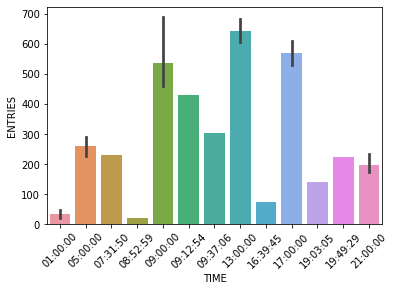

In [262]:

import seaborn
chart = seaborn.barplot(x = roos['TIME'], y = roos['ENTRIES'])
chart.set_xticks(chart.get_xticks())
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)